# CF preprocessing with new modules
In this notebook I use participant class to get my data preprocessed and then I use the visual space and limit vertices functionality I added to prfpy for CF analysis.

In [383]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [384]:
import sys
sys.path.append('/tank/klundert/projects/cfdn/prfpy_cfdn/')
import os
import numpy as np
import preprocess
import cortex as cx
import numpy as np
import scipy as sp
import nilearn as nl
from nilearn.surface import load_surf_data
import os, shutil, urllib.request
import cortex as cx
from matplotlib import rc
import nibabel as nb
from nibabel import cifti2
import h5py
import matplotlib.pyplot as plt
from prfpy.stimulus import PRFStimulus2D
from prfpy.model import Iso2DGaussianModel, CSS_Iso2DGaussianModel
from prfpy.fit import Iso2DGaussianFitter, CSS_Iso2DGaussianFitter
from prfpy.utils import Subsurface
from prfpy.stimulus import CFStimulus
from prfpy.model import CFGaussianModel
from prfpy.fit import CFFitter
from prfpy.model import Norm_CFGaussianModel
from prfpy.fit import Norm_CFGaussianFitter
from scipy.optimize import LinearConstraint, NonlinearConstraint
from scipy.io import loadmat
from scipy.ndimage import median_filter, gaussian_filter, binary_propagation
import natsort
import glob

In [385]:
import h5py
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])
allidxs = np.concatenate([lidxs, ridxs])
def get_cortex(dat):
    l, r, = dat[lidxs], dat[ridxs]

    # Replace the minus 1
    l[lidxs == -1] = np.zeros_like(l[lidxs == -1])
    r[ridxs == -1] = np.zeros_like(r[ridxs == -1])

    # Last dimension time.
    # l, r = l.T, r.T

    data = np.concatenate([l, r])
    return data

def angle(x0, y0):
    return np.angle(x0 + y0 * 1j)

def ecc(x0, y0):
    return np.abs(x0 + y0 * 1j)

def splitList(array):
    n = len(array)
    half = int(n/2) # py3
    return array[:half], array[n-half:]



roi_index_dict = {
    # somatosensory:
    'CS1_4': 8, 'CS2_3a': 53, 'CS3_3b': 9, 'CS4_1': 51, 'CS5_2': 52,
    # auditory:
    'A1': 24, 'PBelt': 124, 'MBelt': 173, 'LBelt': 174, '52': 103, 'RI': 104,
    # low-level visual:
    'V1': 1, 'V2': 4, 'V3': 5,
    # mid-level and high-level visual:
    'V3A': 13, 'V3B': 19, 'IPS1': 17, 'LIPv': 48, 'LIPd': 95, 
    'VIP': 49, 'FEF': 10, 'MST': 2, 'MT': 23, 'LO1': 20, 'LO2': 21, 'LO3': 159
    }

atlas_data = np.concatenate([load_surf_data(
        os.path.join('/tank/klundert/content/data/atlas', f'Q1-Q6_RelatedParcellation210.CorticalAreas_dil_Colors.59k_fs_LR.dlabel.{hemi}.gii'))
         for hemi in ['L', 'R']])
atlas_data_both_hemis = np.mod(atlas_data, 180)


ind = np.array(list(roi_index_dict.values()))[12:]
boolmask = atlas_data_both_hemis == roi_index_dict['V1']
for i, ROIs in enumerate(ind):
  boolmask = np.array(atlas_data_both_hemis == ind[i]) + boolmask
  print(ROIs)

4
5
13
19
17
48
95
49
10
2
23
20
21
159


### preprocessing

In [88]:
subject = 'sub-02'
deriv_dir = '/scratch/2021/nprf_ss/derivatives/'
scalar_dir = '/tank/klundert/projects/means_native/'
ldtr_dir = '/tank/klundert/projects/detrend_psc_native/'
sbj = preprocess.participant(subject, deriv_dir, scalar_dir, ldtr_dir)

In [35]:
idxs = h5py.File('/tank/shared/timeless/atlases/cifti_indices.hdf5', "r")
lidxs = np.array(idxs['Left_indices'])
ridxs = np.array(idxs['Right_indices'])

(59292,)

In [89]:
sbj.sessions
X_conv = np.array([np.ones(115), np.arange(115)]).T
# idx_baseline = np.array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
#         13,  14,  15,  16,  61,  62,  63,  64,  65,  66,  67,  68, 113,
#        114, 115, 116, 117, 118, 119])

idx_baseline = np.array([5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  61,  62,  63,  64,  65,  66,  67,  68, 113,
       114, 115, 116, 117, 118, 119])-5
sbj.linear_detrend_psc_native(X_conv, idx_baseline, 5)

/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:203: RuntimeWarning: invalid value encountered in divide
  psc_data = ((ldt_data - baseline) / baseline) * 100


In [90]:
sbj.get_scalars_native()

In [15]:
os.path.join(scalar_dir, subject, f'{subject}_01_task-prf_run-01_fsnativeLR_mean.npy')

'/tank/klundert/projects/means_native/sub-01/sub-01_01_task-prf_run-01_fsnativeLR_mean.npy'

In [92]:
sbj.lidx

AttributeError: 'participant' object has no attribute 'lidx'

In [94]:
sbj.lidxs = 137801
sbj.ridxs = 139691
sbj.get_folds_detrend_native(remove_edge=True)



processing ses-01


/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


processing ses-02
processing ses-03
processing ses-04


/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:355: RuntimeWarning: Mean of empty slice
  self.data_train = np.nanmean(np.array(data[::2]), axis=0)
/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:356: RuntimeWarning: Mean of empty slice
  self.data_test = np.nanmean(np.array(data[1::2]), axis=0)


In [81]:
np.shape(all_data)

(35, 170494, 115)

In [95]:
all_data = list(sbj.data)
len(all_data)

46

In [83]:
len(all_data)
del all_data[8]
del all_data[6]
len(all_data)


35

In [96]:
data_train = np.nanmean(np.array(all_data[::2]), axis=0)
data_test = np.nanmean(np.array(all_data[1::2]), axis=0)

mean_all = np.nanmean(np.array(all_data), axis=0)

np.save(f'/tank/klundert/projects/fsnative_data/sub-02/data_fold1_detrend_sub-02_psc_fsnative.npy', data_train)
np.save(f'/tank/klundert/projects/fsnative_data/sub-02/data_fold2_detrend_sub-02_psc_fsnative.npy', data_test)
np.save(f'/tank/klundert/projects/fsnative_data/sub-02/data_all_detrend_sub-02_psc_fsnative.npy', mean_all)

/tmp/ipykernel_1972424/16644560.py:1: RuntimeWarning: Mean of empty slice
  data_train = np.nanmean(np.array(all_data[::2]), axis=0)
/tmp/ipykernel_1972424/16644560.py:2: RuntimeWarning: Mean of empty slice
  data_test = np.nanmean(np.array(all_data[1::2]), axis=0)
/tmp/ipykernel_1972424/16644560.py:4: RuntimeWarning: Mean of empty slice
  mean_all = np.nanmean(np.array(all_data), axis=0)


In [97]:
# np.shape(all_data)
check = np.nanmean(np.array(all_data), axis=2)

/tmp/ipykernel_1972424/515050195.py:2: RuntimeWarning: Mean of empty slice
  check = np.nanmean(np.array(all_data), axis=2)


In [100]:
movie = cx.Vertex(check, subject='sub-02', cmap='inferno')

In [102]:
# webgl_data = {'s1_mean': cx.Vertex(mean_all.mean(axis=1), subject='sub-01', cmap='spectral_r', priority=1)}
cx.webgl.show(movie, port=8814, recache=True);

Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 8814
Making HTTP connection to node230:88144H                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [87]:
data_train_std = np.nanstd(np.array(all_data[::2]), axis=0)
data_test_std = np.nanstd(np.array(all_data[1::2]), axis=0)

mean_all_std = np.nanstd(np.array(all_data), axis=0)

np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-01_psc_std.npy', data_train_std)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_detrend_sub-01_psc_std.npy', data_test_std)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_all_detrend_sub-01_psc_std.npy', mean_all_std)

In [77]:
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-02_psc.npy', data_train)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_detrend_sub-02_psc.npy', data_test)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_all_detrend_sub-02_psc.npy', mean_all)



In [14]:
# would run the following if scalars are not already created
# sub.get_scalars()

for sub in [1, 2]:
    s2_f = np.load(f'/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_train_full.npy')
    s2_f2 = np.load(f'/scratch/2021/nprf_ss/derivatives/Scalars/sub-0{sub}/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_mean_timecourse_test_full.npy')



    np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-0{sub}_psc.npy', s2_f)
    np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_sub-0{sub}_psc.npy', s2_f2)

                                                                  


In [32]:
# get the half-half split data (even and uneven runs
sbj.get_folds(remove_edge=True)

/tank/klundert/anaconda3/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:177: RuntimeWarning: Mean of empty slice
  self.data_train = np.nanmean(np.array(data[::2]), axis=0)
/tank/klundert/projects/cfdn/prfpy_cfdn/preprocess.py:178: RuntimeWarning: Mean of empty slice
  self.data_test = np.nanmean(np.array(data[1::2]), axis=0)


In [233]:
np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_detrend_sub-02_psc_fsnative.npy').shape

(277492, 115)

In [18]:
datvol_l = nb.load('/scratch/2021/nprf_ss/derivatives/fmriprep/sub-01/ses-01/func/sub-01_ses-01_task-prf_run-1_space-fsnative_hemi-L_bold.func.gii')
datvol_l.agg_data().shape[0]

153211

In [13]:
# load design matrix of pRF experiment. We use this to determine max eccentricity

dms = loadmat('/scratch/2021/nprf_ss/derivatives/vis_design.mat')['stim'].T

# we have to do a bit of processing on the design matrix. 
# in essence this is a very slowly sampled movie of where the stimulus was on the screen
# you have one frame per TR, so that the analysis becomes easier. 

pixel_offset = int((dms.shape[1] - dms.shape[2]) / 2)
new_dms = np.zeros((dms.shape[0], dms.shape[1], dms.shape[1]))
for timepoint in range(dms.shape[0]):
    square_screen = np.zeros_like(new_dms[timepoint])
    square_screen[:,pixel_offset:pixel_offset+dms.shape[2]] = (dms[timepoint]!=0).astype(float)
    new_dms[timepoint,:,] = gaussian_filter(square_screen, 10).T

# if we then re-sample this design matrix to the same 100 x 100
# pixel space of our models above, our model space and stimulus space align. 

new_dms = new_dms[:,::5,::5]

prf_stim = PRFStimulus2D(screen_size_cm=69, 
                         screen_distance_cm=220, 
                         design_matrix=new_dms.T, 
                         TR=1.5)

grid_nr = 20
max_ecc_size = prf_stim.screen_size_degrees/2.0
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)

print(max_ecc_size)

# mydat_train_stim = np.nan_to_num(np.load(f'/home/klundert/cfdn/data/CF_fit_utils/data_all_detrend_sub-02_psc_fsnative.npy'))

8.912434969522739


### CF analysis

In [508]:
import cortex

In [395]:
import os

def file_exists(folder, filename):
    for file in os.listdir(folder):
        if file == filename:
            return False
    return True

folder = '/tank/klundert/hcp_space_data/hcp_data'
# filename = f'DN_prf_sub-2_fold-1_slice-{i}.npy'

# if file_exists(folder, filename):
#     print(f"{filename} does not exist in {folder}")
# else:
#     print(f"{filename} exists in {folder}")

In [409]:
exist = []
exist2 = []
for i in range(350):
    exist.append(file_exists(folder, f'DN_prf_sub-1_fold-1_slice-{i}.npy'))
    exist2.append(file_exists(folder, f'DN_prf_sub-1_fold-0_slice-{i}.npy'))

In [410]:
np.unique(np.concatenate([np.where(np.array(exist2))[0], np.where(np.array(exist))[0]]))

array([ 23,  49,  50,  79,  80,  81,  82,  83,  84,  85,  86,  87, 149,
       151, 157, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199])

In [411]:
for i in [ 23,  49,  50,  79,  80,  81,  82,  83,  84,  85,  86,  87, 149, 151, 157, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]:
    print(i)

23
49
50
79
80
81
82
83
84
85
86
87
149
151
157
159
190
191
192
193
194
195
196
197
198
199


In [386]:
## data average all folds/subs for each model plus add the average x and y values

### non-WEIGHTED

all_data_gauss = []
all_data_DN = []


for i, sub in enumerate([2]):
    print(sub)
    
    
    for model in ['gauss_prf', 'DN_prf']:
        both_folds = []
        # print(model)
        for folds in [0,1]:

            for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/hcp_space_data/hcp_data/{model}_sub-{sub}_fold-{folds}_slice-*.npy')))):
                # print(j)
                if j == 0:
                    dattest = np.load(infile)
                else:
                    dattest = np.vstack([dattest, np.load(infile)])

                
            both_folds.append(dattest)
        if model == 'gauss_prf':
            all_data_gauss.append(np.mean(both_folds, axis=0))
            
        if model == 'DN_prf':
            all_data_DN.append(np.mean(both_folds, axis=0))
            
prf_gauss = all_data_gauss[0] 
prf_dn = all_data_DN[0]
prf_dn.shape

2


/tank/klundert/anaconda3/envs/cf/lib/python3.10/site-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


ValueError: operands could not be broadcast together with shapes (160734,12) (162198,12) 

In [113]:
## data average all folds/subs for each model plus add the average x and y values

### non-WEIGHTED

all_data_gauss = []
all_data_DN = []


for i, sub in enumerate([2]):
    print(sub)
    
    
    for model in ['gauss_prf', 'DN_prf']:
        both_folds = []
        # print(model)
        

        for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/fsnative_data_u_prf/{model}_sub-{sub}_all_slice-*.npy')))):
            # print(j)
            if j == 0:
                dattest = np.load(infile)
            else:
                dattest = np.vstack([dattest, np.load(infile)])


        both_folds.append(dattest)
        if model == 'gauss_prf':
            all_data_gauss.append(np.mean(both_folds, axis=0))
            
        if model == 'DN_prf':
            all_data_DN.append(np.mean(both_folds, axis=0))
            
prf_gauss = all_data_gauss[0] 
prf_dn = all_data_DN[0]
prf_dn.shape

2


(277492, 8)

In [ ]:
prf

In [347]:
## data average all folds/subs for each model plus add the average x and y values

### WEIGHTED

all_data_gauss = []
all_data_DN = []


for i, sub in enumerate([1]):
    print(sub)
    
    
    for model in ['gauss_prf', 'DN_prf']:
        both_folds = []
        # print(model)
        for folds in [0,1]:

            for j, infile in enumerate(natsort.natsorted((glob.glob(f'/tank/klundert/fsnative_folds_prf/fsnative_data2/{model}_sub-{sub}_fold-{folds}_slice-*.npy')))):
                # print(j)
                if j == 0:
                    dattest = np.load(infile)
                else:
                    dattest = np.vstack([dattest, np.load(infile)])

                
            both_folds.append(dattest)
        if model == 'gauss_prf':
            a = np.array(both_folds)[:,:,-1]
            a[a<0] = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_gauss.append(np.average(both_folds, axis=0, weights=b))
            
        if model == 'DN_prf':
            a = np.array(both_folds)[:,:,-1]
            a[a<0]  = 1e-6
            a[a==0] = 1e-6
            b = np.repeat(a[:, :, np.newaxis], np.array(both_folds).shape[-1], axis=2)
            all_data_DN.append(np.average(both_folds, axis=0, weights=b))
            
prf_gauss = all_data_gauss[0] 
prf_dn = all_data_DN[0]


1


In [375]:
mask

array([False,  True,  True, ..., False, False, False])

In [376]:
sub = 'sub-01'

datvol_l = nb.load(f'/scratch/2021/nprf_ss/derivatives/fmriprep/{sub}/ses-01/func/{sub}_ses-01_task-prf_run-1_space-fsnative_hemi-L_bold.func.gii')
lidx = datvol_l.agg_data().shape[0]

fold = 1

roi_verts = cx.get_roi_verts(f'{sub}', 'V1',mask=True)

maskL=roi_verts['V1'][:lidx]
maskR=roi_verts['V1'][lidx:]
maskL[:] = False


myv1surf=Subsurface(f'{sub}',[maskL,maskR], surftype='fiducial') # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = prf_dn
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

# myv1surf.limit_vertices(gfn_ecc, gfn_rsq, 3, maxrsq = 0.6)
myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.1)

myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

Generating subsurfaces


ValueError: zero-size array to reduction operation maximum which has no identity

array([[       nan, 5.02562426, 5.73885212, 3.33309168, 3.10734168],
       [5.02562426,        nan, 6.95131027, 6.45619709, 2.42585815],
       [5.73885212, 6.95131027,        nan, 3.79021004, 3.66586993],
       [3.33309168, 6.45619709, 3.79021004,        nan, 2.92136652],
       [3.10734168, 2.42585815, 3.66586993, 2.92136652,        nan]])

In [370]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF
# toplot[v1mask] = gfn_ecc[v1mask]

# cx.quickshow(cx.Vertex(toplot, subject='sub-01', cmap='plasma', vmin=0, vmax=9), with_curvature=True)
cx.webshow(cx.Vertex(toplot, subject='sub-01', cmap='plasma', vmin=0, vmax=9), port=8851)

Started server on port 8851
Making HTTP connection to node230:88514H                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

<JS: window.viewer>

Stopping server


Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:231: RuntimeWarning: invalid value encountered in divide
  CMF_matrix = self.distance_matrix/visual_distances


[217.75184866  31.55250353]
[217.75184866  31.55250353]


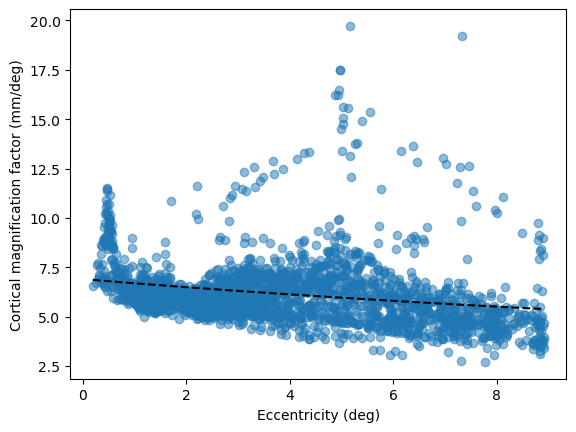

In [316]:
sub = 'sub-02'

datvol_l = nb.load(f'/scratch/2021/nprf_ss/derivatives/fmriprep/{sub}/ses-01/func/{sub}_ses-01_task-prf_run-1_space-fsnative_hemi-L_bold.func.gii')
lidx = datvol_l.agg_data().shape[0]

fold = 1

roi_verts = cx.get_roi_verts(f'{sub}', 'V1',mask=True)

maskL=roi_verts['V1'][:lidx]
maskR=roi_verts['V1'][lidx:]

myv1surf=Subsurface(f'{sub}',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = prf_gauss
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]


myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.6)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

In [331]:
from scipy import stats

bins = stats.binned_statistic(myv1surf.tofit_x, myv1surf.tofit_y, 'median', bins=100)

# plt.plot(bins[1], bins[0])
newbins = []
for i in range(100):
    newbins.append(np.mean([bins[1][0+i], bins[1][1+i]]))
bins[0]

array([ 8.45372987,  7.96571504,  8.70578598,  9.26520904,  9.08482424,
       10.12315442, 10.67889478, 12.1961343 , 13.38068108, 14.03124404,
       18.09176086, 15.58172347, 10.71351665,  8.74914431, 11.392852  ,
       12.25924851, 13.00672192, 12.96950542, 12.95991461, 13.68021716,
       14.96374851, 15.53054395, 14.22072583, 13.87625965, 20.73798804,
       12.13754643, 10.78217299, 11.32192302, 11.95171194, 10.92455436,
        9.91955848, 11.34150445, 11.42025964, 11.3864434 , 12.13871369,
       11.63779503, 12.21162796, 12.18645654, 11.81759012, 11.43470582,
       11.92202141, 10.64142687, 10.9677585 , 10.51887991,  9.04153827,
        8.96608326, 10.65933799,  9.43404052, 10.3194298 ,  9.77573413,
       10.56944502,  9.28854216,  9.82212598,  9.71650218,  9.45454296,
        9.44309255,  9.59909097,  9.77628632,  9.50000171,  8.94470513,
        8.92257285,  8.74786904, 12.47886032,  8.85320483,  8.56660204,
        9.11775898,  9.03940603,  9.40324183,  9.00222011,  9.14

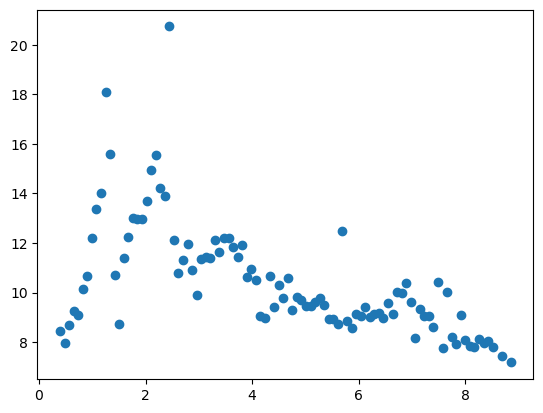

In [332]:
np.array(newbins).shape

plt.scatter(np.array(newbins), bins[0])


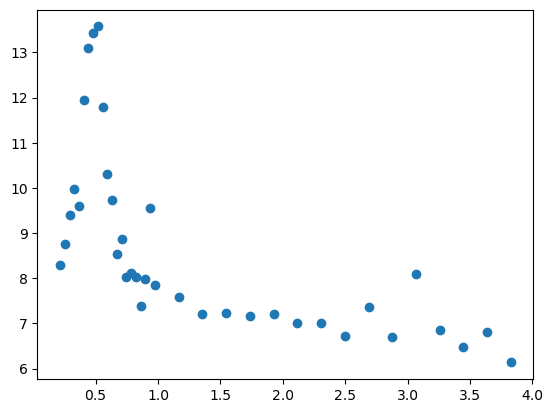

In [155]:
# plt.scatter(np.array(newbins), bins[0])


plt.scatter(np.hstack([np.array(newbins)[:20], np.array(newbins)[20::5]]), np.hstack([bins[0][:20], bins[0][20::5]]))

In [350]:
myv1surf.CMF_matrix.shape

tmask = myv1surf.tofit_x < 1

tmask1 = (myv1surf.tofit_x >= 1) * (myv1surf.tofit_x < 2)
tmask2 = (myv1surf.tofit_x >= 2) * (myv1surf.tofit_x < 3)
tmask3 = (myv1surf.tofit_x >= 3) * (myv1surf.tofit_x < 4)
tmask4 = (myv1surf.tofit_x >= 4) * (myv1surf.tofit_x < 5)
tmask5 = (myv1surf.tofit_x >= 5) * (myv1surf.tofit_x < max_ecc_size)


# ((tofit_x >= 1) * (tofit_x < 2)).sum()

myv1surf.CMF_matrix

fmask = np.ix_(tmask, tmask)
fmask1 = np.ix_(tmask1, tmask1)
fmask2 = np.ix_(tmask2, tmask2)
fmask3 = np.ix_(tmask3, tmask3)
fmask4 = np.ix_(tmask4, tmask4)
fmask5 = np.ix_(tmask5, tmask5)




myv1surf.CMF_matrix[fmask].shape



(343, 343)

In [351]:
a=np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)
b=np.nanmean(myv1surf.CMF_matrix[fmask1], axis=1)
c=np.nanmean(myv1surf.CMF_matrix[fmask2], axis=1)
d=np.nanmean(myv1surf.CMF_matrix[fmask3], axis=1)
e=np.nanmean(myv1surf.CMF_matrix[fmask4], axis=1)
f=np.nanmean(myv1surf.CMF_matrix[fmask5], axis=1)



x = np.concatenate((myv1surf.tofit_x[tmask], myv1surf.tofit_x[tmask1], myv1surf.tofit_x[tmask2], myv1surf.tofit_x[tmask3], myv1surf.tofit_x[tmask4], myv1surf.tofit_x[tmask5]))

y = np.concatenate((a,b,c,d,e,f))






[175.14016643   7.21364225]


Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

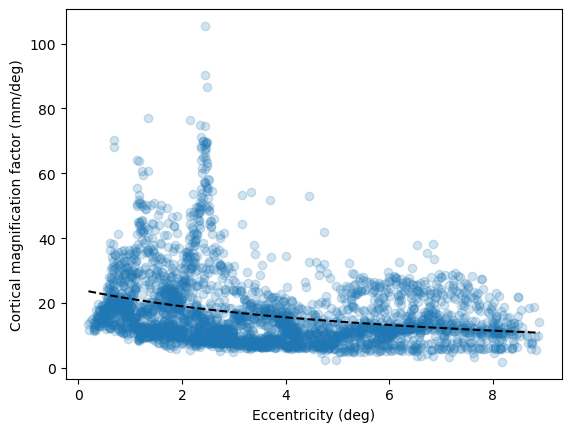

In [354]:
from scipy.optimize import curve_fit

def magnification(x, a, b):
    """magnification
        Function used to fit cortical magnification factor parameters
    """
    return a/(b+x)

incl = 20 # all fist X values
incl_step = 10 # then include every i-th value

tofit_x = np.hstack([np.array(newbins)[:incl], np.array(newbins)[incl::incl_step]])
tofit_y = np.hstack([bins[0][:incl], bins[0][incl::incl_step]])

# tofit_x = myv1surf.tofit_x[myv1surf.tofit_y < 9]
# tofit_y = myv1surf.tofit_y[myv1surf.tofit_y < 9]


tofit_x = myv1surf.tofit_x[tmask]
# tofit_y = myv1surf.tofit_y
tofit_y = np.nanmean(myv1surf.CMF_matrix[fmask], axis=1)

tofit_x = x
tofit_y = y

myv1surf.CMF_matrix

pars, cov = curve_fit(f=magnification, xdata=tofit_x, 
              ydata=tofit_y, p0=[40, 6], method='trf')



# pars = [20.14400586, 0.7611809]

# extract the parameters
lamb, ecc0 = pars

# pars = [50, 4]
print(pars)


plotx = np.linspace(start=np.nanmin(tofit_x), stop=np.nanmax(tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(tofit_x, tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

In [84]:
tofit_x

array([0.23652308, 0.27999595, 0.32346883, 0.3669417 , 0.41041458,
       0.45388745, 0.49736033, 0.5408332 , 0.58430608, 0.62777896,
       0.67125183, 0.71472471, 0.75819758, 0.80167046, 0.84514333,
       0.88861621, 0.93208908, 0.97556196, 1.01903483, 1.06250771,
       1.10598059, 1.14945346, 1.19292634, 1.23639921, 1.27987209,
       1.32334496, 1.36681784, 1.41029071, 1.45376359, 1.49723647,
       1.54070934, 1.58418222, 1.62765509, 1.67112797, 1.71460084,
       1.75807372, 1.80154659, 1.84501947, 1.88849234, 1.93196522,
       1.9754381 , 2.01891097, 2.06238385, 2.10585672, 2.1493296 ,
       2.19280247, 2.23627535, 2.27974822, 2.3232211 , 2.36669397,
       2.41016685, 2.45363973, 2.4971126 , 2.54058548, 2.58405835,
       2.62753123, 2.6710041 , 2.71447698, 2.75794985, 2.80142273,
       2.84489561, 2.88836848, 2.93184136, 2.97531423, 3.01878711,
       3.06225998, 3.10573286, 3.14920573, 3.19267861, 3.23615148,
       3.27962436, 3.32309724, 3.36657011, 3.41004299, 3.45351

Text(0, 0.5, 'Cortical magnification factor (mm/deg)')

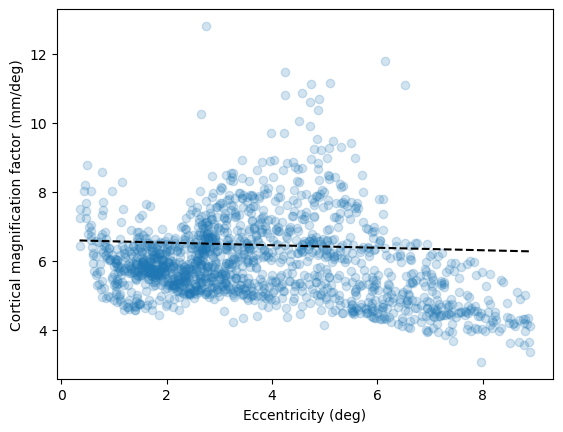

In [380]:
# def magnification(x, a, b):
#     """magnification
#         Function used to fit cortical magnification factor parameters
#     """
#     return a/(b+x)

pars = [1119.17568603, 169.55275004]

plotx = np.linspace(start=np.nanmin(myv1surf.tofit_x), stop=np.nanmax(myv1surf.tofit_x), num=200)
fig, ax = plt.subplots()
ax.scatter(myv1surf.tofit_x, myv1surf.tofit_y, alpha=0.2)
ax.plot(plotx, magnification(plotx, *pars), linestyle='--', color='black')
ax.set_xlabel('Eccentricity (deg)')
ax.set_ylabel('Cortical magnification factor (mm/deg)')

Generating subsurfaces
Creating distance by distance matrices


/tank/klundert/downloads/cfpy/prfpy/utils.py:231: RuntimeWarning: invalid value encountered in divide
  CMF_matrix = self.distance_matrix/visual_distances


[47.62036158  4.02904563]
[47.62036158  4.02904563]


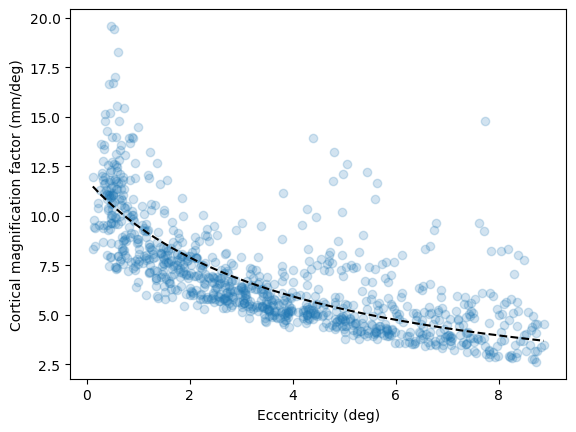

In [377]:
sub = 2
fold = 1

roi_verts = cx.get_roi_verts('hcp_999999', 'V1',mask=True)

maskL=roi_verts['V1'][:59292]
maskR=roi_verts['V1'][59292:]

myv1surf=Subsurface('hcp_999999',[maskL,maskR]) # surf = fiducial, inflated, veryinflated, 
# hyperinflated, superinflated, flat, sphere

myv1surf.create()


# load prf paramaters for creating visual space distance matrix and limiting the vertices
prf_params = get_cortex(np.load(f'/scratch/2021/nprf_ss/derivatives/prf-fits/sub-0{sub}/dn-prf/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_normPRF_params_cv_fold{fold}.npy'))
gfn_ecc = ecc(prf_params[:,0], prf_params[:,1])
gfn_rsq = prf_params[:,-1]

myv1surf.limit_vertices(gfn_ecc, gfn_rsq, max_ecc_size, maxrsq = 0.4)
myv1surf.create_visual_space(prf_params[:,0], prf_params[:,1])

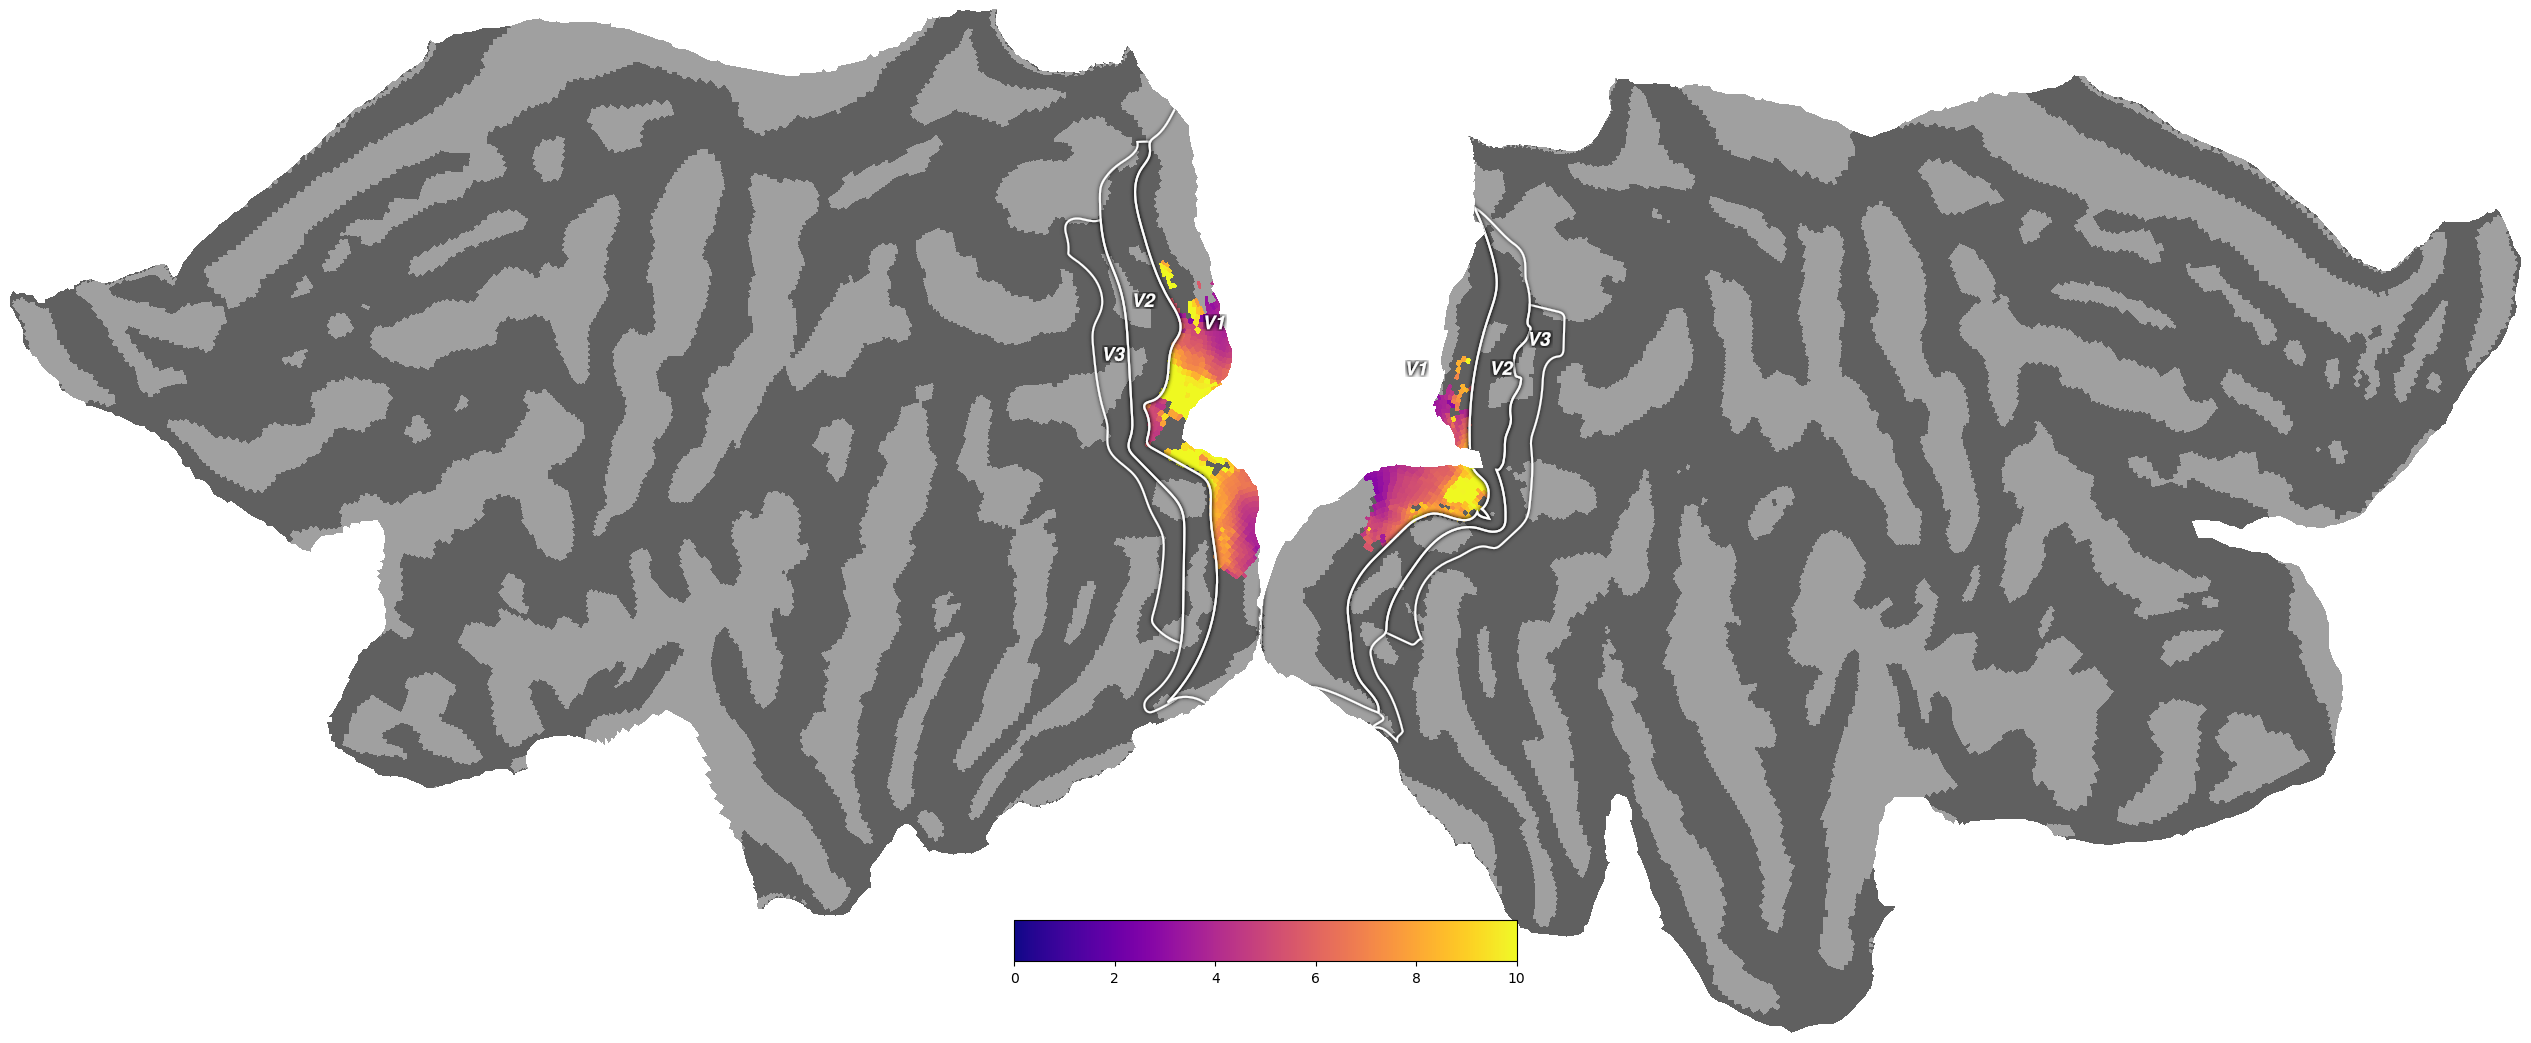

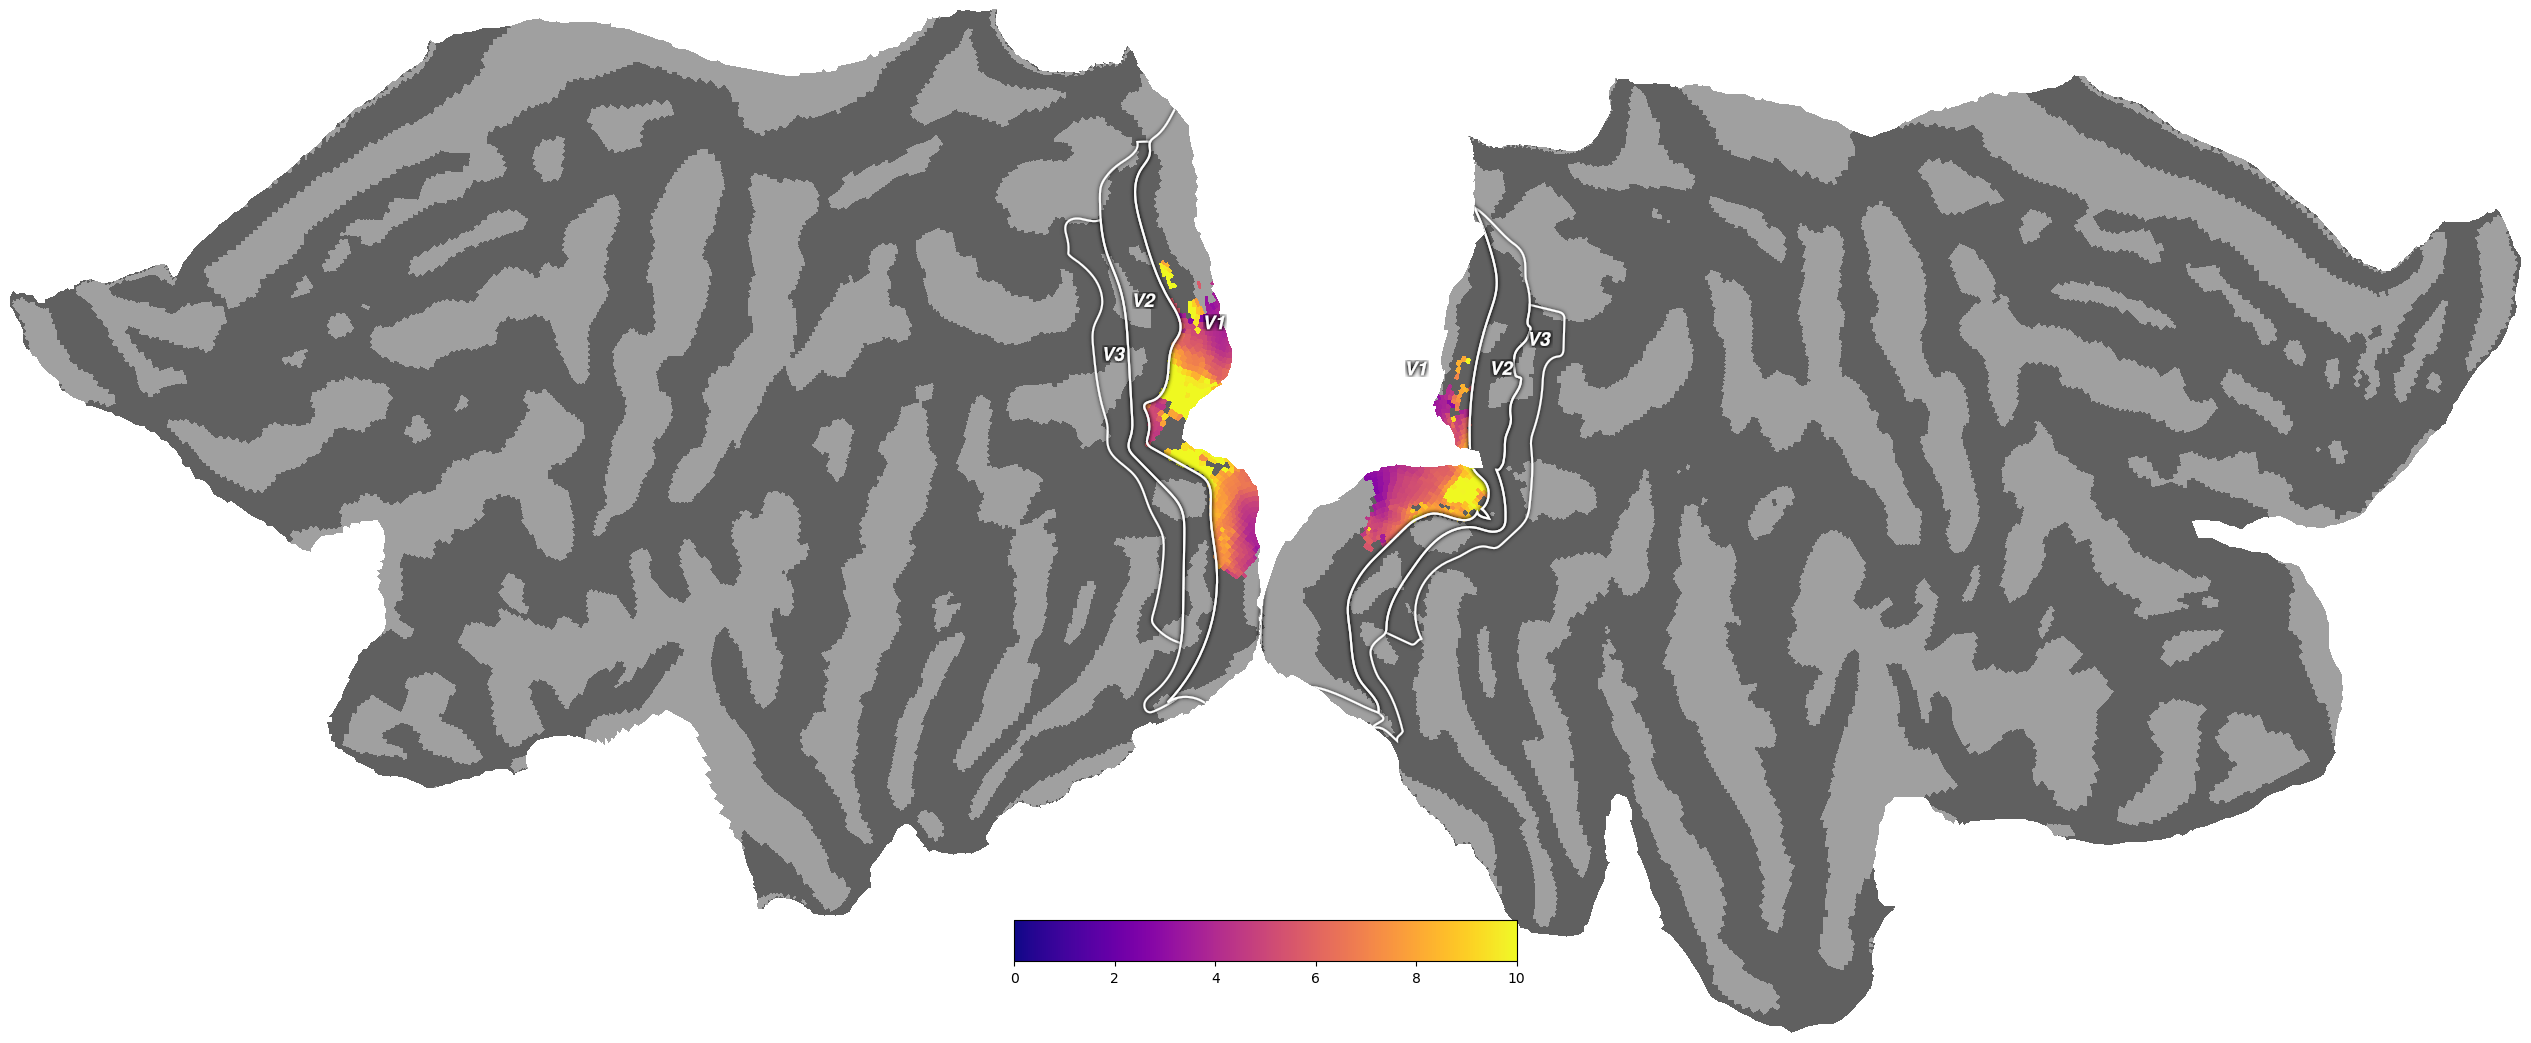

In [32]:
v1mask = myv1surf.intmask.astype(bool)

toplot = np.zeros([myv1surf.intmask.size])
toplot[:] = np.nan
toplot[v1mask] = myv1surf.CMF
cx.quickshow(cx.Vertex(toplot, subject='hcp_999999', cmap='plasma', vmin=0, vmax=10), with_curvature=True)


In [221]:
myv1surf.visual_distance_matrix
# myv1surf.logvisual_distance_matrix

array([[0.        , 0.1867309 , 0.19251213, ..., 3.03863345, 0.87498388,
        8.78891561],
       [0.1867309 , 0.        , 0.15260642, ..., 2.91821435, 0.77660267,
        8.61236016],
       [0.19251213, 0.15260642, 0.        , ..., 3.06444443, 0.92883665,
        8.71309801],
       ...,
       [3.03863345, 2.91821435, 3.06444443, ..., 0.        , 2.16720745,
        6.33038931],
       [0.87498388, 0.77660267, 0.92883665, ..., 2.16720745, 0.        ,
        8.07876231],
       [8.78891561, 8.61236016, 8.71309801, ..., 6.33038931, 8.07876231,
        0.        ]])

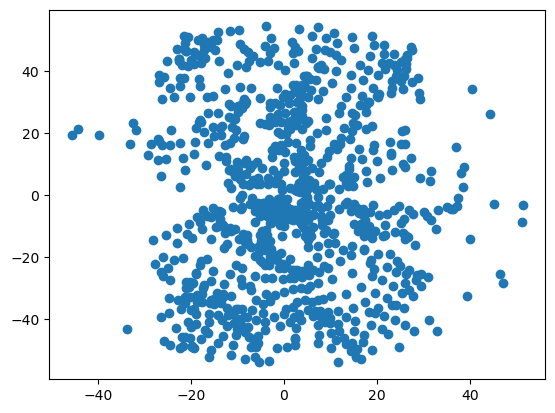

In [482]:
plt.scatter(myv1surf.logxy_verts['logx'], myv1surf.logxy_verts['logy'])

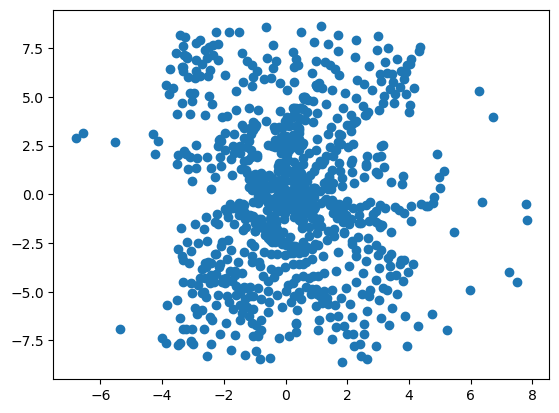

In [483]:
plt.scatter(myv1surf.xy_verts['x'], myv1surf.xy_verts['y'])

In [230]:
sub=2
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/subsurface_verts_sub-0{sub}_fsnative.npy', myv1surf.subsurface_verts)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/logvisual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.logvisual_distance_matrix)
np.save(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_distance_matrix_sub-0{sub}_fsnative.npy', myv1surf.visual_distance_matrix)

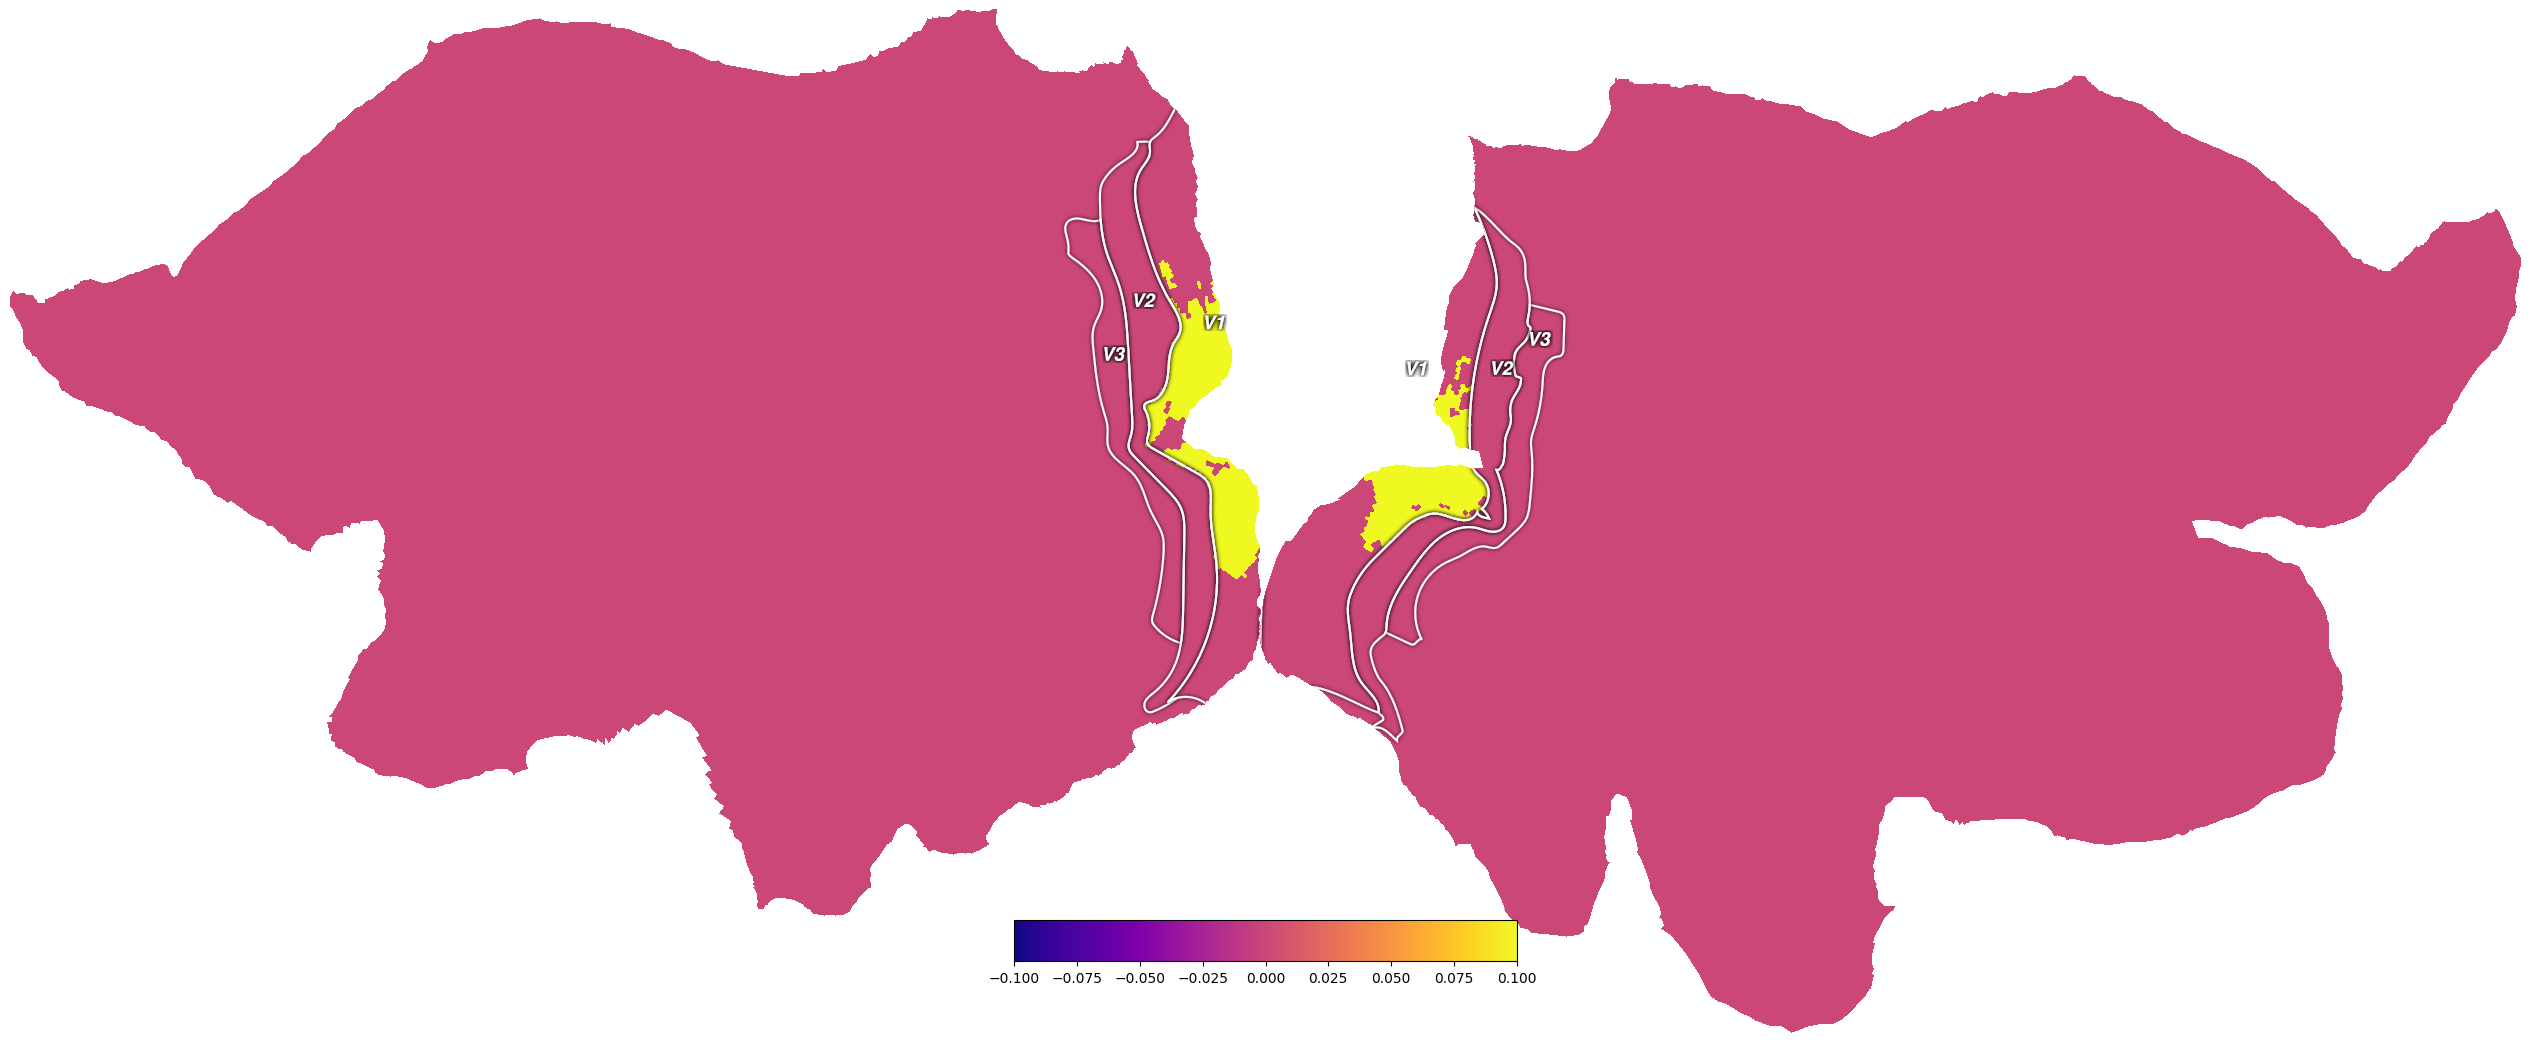

In [9]:
# myv1surf.intmask is a binary mask that shows which vertices we use for CF sampling
cx.quickshow(cx.Vertex(myv1surf.intmask, subject='hcp_999999', cmap='plasma'), with_curvature=True);


In [10]:
# get the data in format for CF analysis

boolmask = np.load('/tank/klundert/projects/cfdn/data/CF_fit_utils/visual_mask_hcp.npy')

sub=2
mydat_train = np.nan_to_num(get_cortex(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-0{sub}.npy'))[:,10:])
mydat_test = np.nan_to_num(get_cortex(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_sub-0{sub}.npy'))[:,10:])

# create stimuli objects
train_stim=CFStimulus(mydat_train, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)
test_stim=CFStimulus(mydat_test, myv1surf.subsurface_verts, myv1surf.logvisual_distance_matrix)

# get data in format for CF analysis, but now only a portion of the cortex for faster
# analysis. You have to do this after creating the stimuli objects.
mydat_train = np.nan_to_num(get_cortex(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-0{sub}.npy'))[:,10:])[boolmask]
mydat_test = np.nan_to_num(get_cortex(np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold2_sub-0{sub}.npy'))[:,10:])[boolmask]



In [13]:
np.load(f'/tank/klundert/projects/cfdn/data/CF_fit_utils/data_fold1_sub-01.npy').shape

(170494, 120)

In [69]:
gf_vis.gridsearch_params[:,3]

np.array([0,1]).reshape(-1, 1)

array([[0],
       [1]])

In [84]:
spliced_lookup_xy = myv1surf.xy_frame_all.iloc[gf_vis.gridsearch_params[:,3].astype(int),:]

np.array(spliced_lookup_xy.iloc[0]).reshape(1, -1)

array([[ 2.943917  , -7.77252811]])

In [87]:
from sklearn.metrics.pairwise import euclidean_distances, paired_distances
euclidean_distances(np.array(spliced_lookup_xy.iloc[0]).reshape(1, -1), spliced_lookup_xy)



array([[0.        , 6.81539096, 5.66618869, ..., 9.02518804, 9.37090272,
        9.02518804]])

In [54]:
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 25
# Perform the fitting.
gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)

Each batch contains approx. 226 voxels.


[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  60 out of  60 | elapsed:   11.6s finished


In [41]:
model=CFGaussianModel(train_stim)

# Define sigmas
sigmas=np.array([0.5,1,2,3,4,5,7,10,20,30,40,60,80,110])

# Define the fitter
gf_vis = CFFitter(data=mydat_train,model=model)
gf_vis.n_jobs = 25
# Perform the fitting.
gf_vis.grid_fit(sigmas, verbose=True, n_batches=60)

CF_bounds = [(0.1, 150),  # sigmas
                (0, 1000),  # beta
                (0, 0.0001), # baseline
                (0, 0)] # vert

CF_bounds = np.array(CF_bounds)
CF_bounds = np.repeat(CF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
CF_bounds[:,3,0] = gf_vis.vertex_centres
CF_bounds[:,3,1] = gf_vis.vertex_centres

gf_vis.iterative_fit(rsq_threshold=-1, verbose=True, constraints=[], starting_params=gf_vis.gridsearch_params, bounds=CF_bounds, ftol=1e-7, xtol=1e-7)

# get model predictions
fit_stimulus = np.copy(gf_vis.model.stimulus)
gf_vis.model.stimulus = test_stim

sigmasi, betai, baselinei, vert_centrei, R2i = np.copy(gf_vis.iterative_search_params.T)
model_tc_vis = np.zeros(mydat_train.shape)
i = 0
for i in range(np.size(vert_centrei)):
    model_tc_vis[i,:] = gf_vis.model.return_prediction(sigmasi[i], betai[i], baselinei[i], vert_centre[i])

gf_vis.model.stimulus = train_stim

# crossvalidate rsq
CV_rsq = np.nan_to_num(1-np.sum((mydat_test-model_tc_vis)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))
CV_rsq[CV_rsq <= -1] = np.nan
CV_rsq[CV_rsq >= 1] = np.nan

gf_vis.iterative_search_params[:,-1] = CV_rsq
gf_vis.iterative_search_params[:,3] = vert_centre

np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_gauss_CF_params_LOGvisual_space_fold{fold}_zsc.npy', gf_vis.iterative_search_params)



DNCF_bounds = [(0.1, 150),  # sigmas
            (0, 1000),  # prf amplitude
            (0, 0.0001), # baseline (A)
            (0, 0), # vert
            (0, 1000), # srf amplitude (C)
            (0.3, 100), # surround sigma 
            (0, 1000), # neural baseline (B)
            (1e-6, 1000)] # surround baseline (D)


DNCF_bounds = np.array(DNCF_bounds)
DNCF_bounds = np.repeat(DNCF_bounds[np.newaxis,...], gf_vis.gridsearch_params.shape[0], axis=0)
DNCF_bounds[:,3,0] = gf_vis.vertex_centres
DNCF_bounds[:,3,1] = gf_vis.vertex_centres

# set constraint for surround>centre sigma
constraints_gauss, constraints_css, constraints_dog, constraints_norm = [],[],[],[]
A_ssc_norm = np.array([[-1,0,0,0,0,1,0,0]])  
constraints_norm.append(LinearConstraint(A_ssc_norm,
                                            lb=0,
                                            ub=+np.inf))

gfdn = Norm_CFGaussianModel(train_stim)

fitdn = Norm_CFGaussianFitter(data=mydat_train,
                                   model=gfdn,
                                   n_jobs=40,
                                   previous_gaussian_fitter=gf_vis)

fitdn.iterative_fit(rsq_threshold=-1, verbose=True, constraints=constraints_norm, starting_params=gf_vis.iterative_search_params, bounds=DNCF_bounds, ftol=1e-7, xtol=1e-7)

sig, pamp, boldb, verti, srfamp, srfsig, neurb, surrb, Rsq = fitdn.iterative_search_params.T

fit_stimulus = np.copy(fitdn.model.stimulus)
fitdn.model.stimulus = test_stim

dncf_tc = np.zeros(mydat_test.shape)
i = 0
for i in range(np.size(vert_centrei)):
    dncf_tc[i,:] = fitdn.model.return_prediction(sig[i], pamp[i], boldb[i], vert_centre[i], srfamp[i], srfsig[i], neurb[i], surrb[i])

fitdn.model.stimulus = train_stim

CVdncf_rsq = np.nan_to_num(1-np.sum((mydat_test-dncf_tc)**2, axis=-1)/(mydat_test.shape[-1]*mydat_test.var(-1)))

CVdncf_rsq[CVdncf_rsq <= -1] = np.nan
CVdncf_rsq[CVdncf_rsq >= 1] = np.nan

fitdn.iterative_search_params[:,-1] = CVdncf_rsq
fitdn.iterative_search_params[:,3] = vert_centre

# np.save(f'/scratch/2021/nprf_ss/derivatives/cf-fits/sub-0{sub}/limit_sample_gauss/visual_space/sub-0{sub}_task-prf_space-fsLR_den-170k_desc-preproc_norm_CF_params_LOGvisual_space_fold{fold}_zsc.npy', fitdn.iterative_search_params)

array([ 45371.,  45294., 101375., ...,  45438.,  45438.,  45367.])

NameError: name 'fitdn' is not defined